In [1]:
!pip install torchvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 72.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 50.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 34.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 64.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlink

##Load data

In [ ]:
import torch
import torch.nn as nn
from PIL import Image
from torchvision import transforms
from IPython.display import display

img_size = 256

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

img_transforms = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor()
])

def img_loader(image_path):
  image = Image.open(image_path)
  image = img_transforms(image).unsqueeze(0)

  return image.to(device, torch.float)

content_img = img_loader('images/saitama.jpg')
style_img1 = img_loader('images/style_1.jpg')
style_img2 = img_loader('images/style_2.jpg')

##Compute Gram matrix

In [4]:
content_weight = 1
Content_loss = nn.MSELoss()

def gram_matrix(tensor):
  a, b, c, d = tensor.shape
  tensor = tensor.view(a * b, c * d)
  G = torch.mm(tensor, tensor.t())

  return G.div(a * b * c * d)

style_weight = 1e6
Style_loss = nn.MSELoss()

##Load pretrained model

In [5]:
from torchvision.models import vgg19, VGG19_Weights

model = vgg19(weights=VGG19_Weights.DEFAULT).features.eval()
model.to(device)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:06<00:00, 84.3MB/s]


Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

##Def Normalization

In [6]:
def normalization(image):
  img_transforms = transforms.Compose([
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
  ])

  return img_transforms(image)

##Get features

In [7]:
content_layers = ['conv_4']
style_layers = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_features(model, image):
  layers = {
    '0': 'conv_1',
    '5': 'conv_2',
    '10': 'conv_3',
    '19': 'conv_4',
    '28': 'conv_5'
  }

  features = {}

  x = image
  x = normalization(x)

  for name, pretrained_layer in model._modules.items():
    x = pretrained_layer(x)
    if name in layers:
      features[layers[name]] = x

  return features

In [8]:
content_features = get_features(model, content_img)
style_features1 = get_features(model, style_img1)
style_features2 = get_features(model, style_img2)

##Get final features

In [9]:
def get_dual_style(style_features1, style_features2, style_layers):
  final_style_features = {}
  for feature in style_layers:
    sf1 = style_features1[feature]
    sf2 = style_features2[feature]

    feature_size1 = sf1.shape[1] // 4

    combine_feature =  torch.cat((sf1[:, :feature_size1, :, :], sf2[:, feature_size1:, :, :]), dim=1)

    final_style_features[feature] = combine_feature

  return final_style_features

In [43]:
final_style_features = get_dual_style(style_features1, style_features2, style_layers)

##Define optim

In [11]:
import torch.optim as optim
target_img = content_img.clone().requires_grad_(True).to(device, torch.float)
optimizer = optim.Adam([target_img], lr=0.02)

##Train

In [12]:
def style_transfer(model, optimizer, target_img, content_features, style_features,
                   style_layers, content_weight, style_weight):
  optimizer.zero_grad()
  with torch.no_grad():
    target_img.clamp_(0, 1)
  target_features = get_features(model, target_img)

  content_loss = Content_loss(content_features['conv_4'], target_features['conv_4'])

  style_loss = 0
  for layer in style_layers:
    target_gram = gram_matrix(target_features[layer])
    style_gram = gram_matrix(style_features[layer])
    style_loss += Style_loss(target_gram, style_gram)

  total_loss = content_weight * content_loss + style_weight * style_loss
  total_loss.backward(retain_graph=True)
  optimizer.step()

  return total_loss, content_loss, style_loss

In [13]:
STEPS = 500

for step in range(STEPS):
  optimizer.zero_grad()
  with torch.no_grad():
    target_img.clamp_(0, 1)

  total_loss, content_loss, style_loss = style_transfer(model, optimizer, target_img, content_features,
                                                        final_style_features, style_layers,
                                                        content_weight, style_weight)
  if step % 100 == 99:
    print(f"Epoch [{step + 1}/{STEPS}] Total loss: {total_loss.item():.6f} - "
          f"Content loss: {content_loss.item():.6f} - Style loss: {style_loss.item():.6f}")
  with torch.no_grad():
    target_img.clamp_(0, 1)

Epoch [100/500] Total loss: 55.002556 - Content loss: 13.078259 - Style loss: 0.000042
Epoch [200/500] Total loss: 50.591179 - Content loss: 13.054966 - Style loss: 0.000038
Epoch [300/500] Total loss: 48.336708 - Content loss: 12.941786 - Style loss: 0.000035
Epoch [400/500] Total loss: 48.704559 - Content loss: 12.748731 - Style loss: 0.000036
Epoch [500/500] Total loss: 46.525803 - Content loss: 13.027487 - Style loss: 0.000033


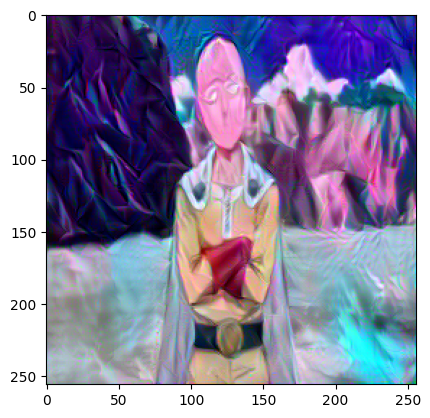

In [39]:
import matplotlib.pyplot as plt

target_img = target_img.squeeze(0)
target_img = target_img.permute(1, 2, 0)
plt.imshow(target_img.cpu().detach().numpy())
plt.show()

##Def Rot feature and Train

In [44]:
def rot_style_features(style_features, style_layers):
  final_style_features = {}
  for layer in style_layers:
    sf = style_features[layer].clone()
    sf90 = torch.rot90(sf, 1, [2, 3])
    sf180 = torch.rot90(sf90, 1, [2, 3])

    final_rot = sf + (sf90 - sf180)
    final_style_features[layer] = final_rot

  return final_style_features

In [45]:
rot_style_features = rot_style_features(style_features1, style_layers)

In [48]:
import torch.optim as optim
target_img1 = content_img.clone().requires_grad_(True).to(device, torch.float)
target_img2 = content_img.clone().requires_grad_(True).to(device, torch.float)
optimizer1 = optim.Adam([target_img1], lr=0.02)
optimizer2 = optim.Adam([target_img2], lr=0.02)

In [58]:
STEPS = 5000

for step in range(STEPS):

  total_loss1, content_loss1, style_loss1 = style_transfer(model, optimizer1, target_img1,
                                                           content_features, style_features1,
                                                           style_layers, content_weight, style_weight)
  total_loss2, content_loss2, style_loss2 = style_transfer(model, optimizer2, target_img2,
                                                           content_features, rot_style_features,
                                                           style_layers, content_weight, style_weight)
  if step % 100 == 99:
    print(f"Epoch [{step + 1}/{STEPS}] Total loss1: {total_loss1.item():.6f} - "
          f"Content loss1: {content_loss1.item():.6f} - Style loss1: {style_loss1.item():.6f}")

    print(f"Epoch [{step + 1}/{STEPS}] Total loss2: {total_loss2.item():.6f} - "
          f"Content loss2: {content_loss2.item():.6f} - Style loss2: {style_loss2.item():.6f}")
  with torch.no_grad():
    target_img1.clamp_(0, 1)
    target_img2.clamp(0, 1)

Epoch [100/5000] Total loss1: 17.258873 - Content loss1: 8.746511 - Style loss1: 0.000009
Epoch [100/5000] Total loss2: 173.155075 - Content loss2: 23.011549 - Style loss2: 0.000150
Epoch [200/5000] Total loss1: 12.848880 - Content loss1: 7.665811 - Style loss1: 0.000005
Epoch [200/5000] Total loss2: 173.267242 - Content loss2: 22.216948 - Style loss2: 0.000151
Epoch [300/5000] Total loss1: 15.619310 - Content loss1: 8.819095 - Style loss1: 0.000007
Epoch [300/5000] Total loss2: 171.417206 - Content loss2: 23.047432 - Style loss2: 0.000148
Epoch [400/5000] Total loss1: 12.492435 - Content loss1: 7.791695 - Style loss1: 0.000005
Epoch [400/5000] Total loss2: 171.917404 - Content loss2: 22.390486 - Style loss2: 0.000150
Epoch [500/5000] Total loss1: 22.827202 - Content loss1: 8.419127 - Style loss1: 0.000014
Epoch [500/5000] Total loss2: 169.656509 - Content loss2: 22.457535 - Style loss2: 0.000147
Epoch [600/5000] Total loss1: 12.476877 - Content loss1: 7.592646 - Style loss1: 0.000005


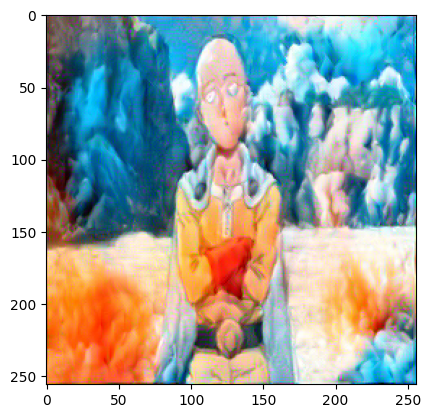

In [59]:
target_img1 = target_img1.squeeze(0)
target_img1 = target_img1.permute(1, 2, 0)
plt.imshow(target_img1.cpu().detach().numpy())
plt.show()

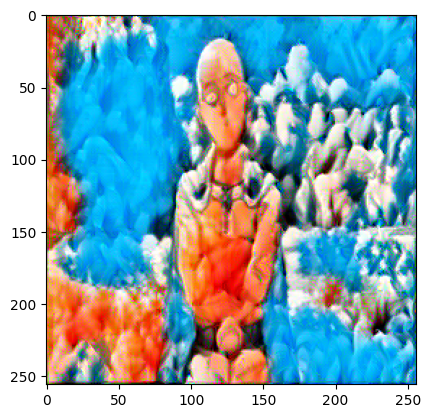

In [60]:
target_img2 = target_img2.squeeze(0)
target_img2 = target_img2.permute(1, 2, 0)
plt.imshow(target_img2.cpu().detach().numpy())
plt.show()